<a href="https://colab.research.google.com/github/prat8897/DL_PyTorch/blob/master/Chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The mechanics of learning

This chapter covers
- Understanding how algorithms can learn from data
- Reframing learning as parameter estimation, using differentiation and gradient descent
- Walking through a simple learning algorithm
- How PyTorch supports learning with autograd

## Learning is just parameter estimation

Given input data and the corresponding desired outputs (*ground truth*), as well as initial values for the weights, the model is fed input data (*forward pass*), and a measure of the *error* is evaluated by comparing the resulting outputs to the ground truth. In order to optimize the parameter of the model—its weights—the change in the error following a unit change in weights (that is, the gradient of the error with respect to the parameters) is computed using the chain rule for the derivative of a composite function (*backward pass*). The value of the weights is then updated in the direction that leads to a decrease in the error. The procedure is repeated until the error, evaluated on unseen data, falls below an acceptable level.

### A hot problem

We just got back from a trip to some obscure location, and we brought back a fancy, wall-mounted analog thermometer. It looks great, and it’s a perfect fit for our living room. Its only flaw is that it doesn’t show units. Not to worry, we’ve got a plan: we’ll build a dataset of readings and corresponding temperature values in our favorite units, choose a model, adjust its weights iteratively until a measure of the error is low enough, and finally be able to interpret the new readings in units we understand.

We’ll start by making a note of temperature data in good old Celsius and measurements from our new thermometer, and figure things out. After a couple of weeks, here’s the data [(code/p1ch5/1_parameter_estimation.ipynb)](https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch5/1_parameter_estimation.ipynb):

In [28]:
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [29]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Here, the `t_c` values are temperatures in Celsius, and the `t_u` values are our unknown units. We can expect noise in both measurements, coming from the devices themselves and from our approximate readings. For convenience, we’ve already put the data into tensors; we’ll use it in a minute.


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

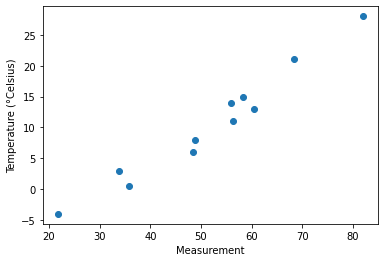

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt

In the absence of further knowledge, we assume the simplest possible model for converting between the two sets of measurements.

The two may be linearly related—that is, multiplying `t_u` by a factor and adding a constant, we may get the temperature in Celsius (up to an error that we omit):

```
t_c = w * t_u + b
```

(looks just like `y = mx + b`, `m` being the `slope` and `b` being the `coefficient`)

We chose to name `w` and `b` after `weight` and `bias`, two very common terms for linear scaling and the additive constant.

Now we need to estimate `w` and `b`, the parameters in our model, based on the data we have. We must do it so that temperatures we obtain from running the unknown temperatures `t_u` through the model are close to temperatures we actually measured in Celsius. If that sounds like fitting a line through a set of measurements, well, yes, because that’s exactly what we’re doing. We’ll go through this simple example using PyTorch and realize that training a neural network will essentially involve changing the model for a slightly more elaborate one, with a few (or a metric ton) more parameters.

To summarise, we have a model with some unknown parameters, and we need to estimate those parameters so that the error between predicted outputs and measured values is as low as possible. We notice that we still need to exactly define a measure of the error. Such a measure, which we refer to as the loss function, should be high if the error is high and should ideally be as low as possible for a perfect match. Our optimization process should therefore aim at finding `w` and `b` so that the *loss
function* is at a minimum.

## Loss functions

A *loss function* (or *cost function*) is a function that computes a single numerical value that the learning process will attempt to minimize. The calculation of loss typically involves taking the difference between the desired outputs for some training samples and the outputs actually produced by the model when fed those samples. In our case, that would be the difference between the predicted temperatures `t_p` output by our model and the actual measurements `t_c` =>  `t_p – t_c`

We need to make sure the *loss function* makes the loss positive both when `t_p` is greater than and when it is less than the true `t_c`, since the goal is for `t_p` to match `t_c`. We have a few choices, the most straightforward being `|t_p – t_c|` and `(t_p – t_c)^2`. Based on the mathematical expression we choose, we can emphasize or discount certain errors. Conceptually, a *loss function* is a way of prioritizing which errors to fix from our training samples, so that our parameter updates result in adjustments to the outputs for the highly weighted samples instead of changes to some other samples output that had a smaller loss.


Both of the example loss functions have a clear minimum at zero and grow monotonically as the predicted value moves further from the true value in either direction.

Because the steepness of the growth also monotonically increases away from the minimum, both of them are said to be *convex*. Since our model is linear, the loss as a function of `w` and `b` is also *convex*. 

We’ve already created our data tensors, so now let’s write out the model as a Python function:



In [31]:
def model(t_u, w, b):
  return (t_u * w) + b


We’re expecting `t_u`, `w`, and `b` to be the *input tensor*, *weight parameter*, and *bias parameter*, respectively.

In our model, the parameters will be PyTorch scalars (aka zero-dimensional tensors), and the product operation will use broadcasting to yield
the returned tensors.

Let's define our loss:

In [32]:
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()


Note that we are building a tensor of differences, taking their square element-wise, and finally producing a scalar loss function by averaging all of the elements in the resulting tensor. It is a **mean square loss**.


We can now initialize the parameters and invoke the model:

In [33]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

At this point, `t_p` is the same as `t_u` because all weights are `1` and biases are `0`.

This will change once we update `t_p`'s values with the help of our *loss function*:

In [34]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

## Decreasing loss

We’ll optimize the loss function with respect to the parameters using the gradient descent algorithm.

The idea of **Gradient Descent** is to compute the rate of change of the loss with respect to each parameter, and modify each parameter in the direction of decreasing loss.

We can estimate the rate of change along each parameter by adding a small number to `w` and `b` and seeing how much the loss changes in that neighborhood:



In [35]:
delta = 0.1
loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)
loss_rate_of_change_w

tensor(4517.2979)

This is saying that in the neighborhood of the current values of `w` and `b`, a unit increase in `w` leads to some change in the loss. If the change is negative, then we need to increase `w` to minimize the loss, whereas if the change is positive, we need to decrease `w`. By how much? Applying a change to `w` that is proportional to the rate of change of the loss is a good idea, especially when the loss has several parameters: we apply a change to those that exert a significant change on the loss. It is also wise to change the parameters slowly in general, because the rate of change could be dramatically different at a distance from the neighborhood of the current `w` value. Therefore, we typically should scale the rate of change by a small factor. This scaling factor has many names; the one we use in machine learning is `learning_rate`:

In [36]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

We can do the same with `b`:

In [37]:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b


This represents just **one** basic parameter-update step for gradient descent. By reiterating these evaluations (and provided we choose a small enough learning rate), we will converge to an optimal value of the parameters for which the loss computed on the given data is minimal. We’ll show the complete iterative process soon, but the way we just computed our rates of change is rather crude and needs an upgrade before we move on. Let’s see why and how.

## Getting analytical


Computing the rate of change by using repeated evaluations of the model and loss in order to probe the behavior of the loss function in the neighborhood of `w` and `b` doesn’t scale well to models with many parameters. Also, it is not always clear how large the neighborhood should be. We chose `delta` equal to `0.1` in the previous section, but it all depends on the shape of the loss as a function of `w` and `b`. If the loss changes too quickly compared to delta, we won’t have a very good idea of in which direction the loss is decreasing the most.

What if we could make the neighborhood infinitesimally small? That’s exactly what happens when we analytically take the derivative of the loss with respect to a parameter. In a model with two or more parameters like the one we’re dealing with, we compute the individual derivatives of the loss with respect to each parameter and put them in a vector of derivatives: the *gradient*.

### Computing the Derivatives

In order to compute the derivative of the loss with respect to a parameter, we can apply the chain rule and compute the derivative of the loss with respect to its input (which is the output of the model), times the derivative of the model with respect to the parameter.

Output of model `w * t_u + b` is `t_p`, therefore

```
d(loss_fn)/dw = d(loss_fn)/d(w * t_u + b) * d(w * t_u + b)/dw
```
becomes 
```
d(loss_fn)/dw = d(loss_fn)/d(t_p) * d(t_p)/dw
```



Recall that our model is a linear function, and our loss is a sum of squares. Let’s figure out the expressions for the derivatives. Recalling the expression for the loss:



```
def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()
```

Remembering that `d(x^2) / dx = 2x`, we get

In [38]:
def dloss_fn(t_p, t_c):
  dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) #The division is from the derivative of mean.
  return dsq_diffs

### Applying the derivatives to the model

For the model, recalling that our model is

```
def model(t_u, w, b):
    return w * t_u + b
```

we get these derivatives:


`d(w * t_u + b) / dw = t_u`

`d(w * t_u + b) / db = 1`


In [39]:
def dmodel_dw(t_u, w, b):
  return t_u

In [40]:
def dmodel_db(t_u, w, b):
  return 1.0

### Defining the **Gradient Function**

We take derivatives of the loss function with respect to `w` and `b`:

`d(loss_fn)/dw = d(loss_fn)/d(t_p) * d(t_p)/dw`

`d(loss_fn)/db = d(loss_fn)/d(t_p) * d(t_p)/db`

Putting all of this together, the function returning the gradient of the loss with respect to `w` and `b` is:

In [41]:
def grad_fn(t_u, t_c, t_p, w, b):
  dloss_dtp = dloss_fn(t_p, t_c)
  dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
  dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
  return torch.stack([dloss_dw.sum(), dloss_db.sum()])

The summation `dloss_dw.sum()` and `dloss_db.sum()` is the reverse of the broadcasting we implicitly do when applying the parameters to an entire vector of inputs in the model.

We’re averaging (that is, summing and dividing by a constant) over all the data points to get a single scalar quantity for each partial derivative of the loss.